In [4]:
%matplotlib inline

In [54]:
import os, itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold


def plot_cm(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    """
    print('Confusion matrix')
    print(cm)
    """
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True')
    plt.xlabel('Predicted')

# Set up folders and filenames for both, applicants and hires
work_dir = os.getcwd()
data_dir = work_dir + '/data'

files = [(root, dirs, files) for root, dirs, files in os.walk(data_dir)].pop()[-1]
train = dict((f.split('.')[0].split('_')[-1], data_dir + '/' + f) for f in files)

# Read the data into data frames
apps = pd.read_csv(train['applicants'])
hires = pd.read_csv(train['hires'])
both = apps.merge(hires, how='inner', on='user_id')

In [6]:
# Find columns with missing values in hires
hires.isnull().any()

user_id               False
client                False
tenure_length          True
currently_employed    False
hire_job_category     False
dtype: bool

In [7]:
# Find columns with missing values in apps
apps.isnull().any()

user_id           False
client_name       False
answer1            True
answer2           False
answer3            True
answer4            True
answer5            True
answer6            True
answer7            True
answer8            True
answer9            True
answer10           True
answer11           True
answer12          False
answer13           True
answer14           True
answer15           True
answer16           True
answer17           True
answer18           True
answer19           True
answer20           True
answer21           True
answer22           True
answer23           True
answer24           True
answer25           True
log_total_time     True
device             True
dtype: bool

In [10]:
# Find proportions of applicants by client
apps.client_name.value_counts()

client11    6701
client10    2123
client4      676
client9      453
Name: client_name, dtype: int64

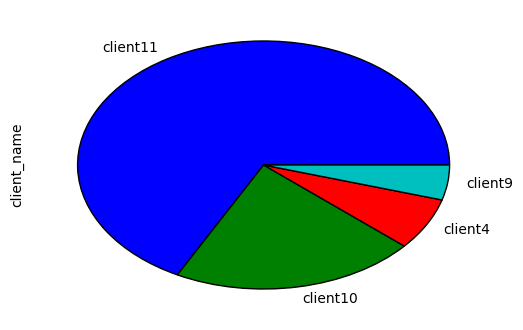

In [13]:
# Display a pie chart for proportions of applicants by client
apps.client_name.value_counts().plot(x=None, y=None, kind='pie')

In [14]:
# Find proportions of hires by client
hires.client.value_counts()

client11    1674
client5     1448
client3      978
client10     961
client9      696
client2      521
client8      277
client7      223
client4      187
client1      104
client6       47
Name: client, dtype: int64

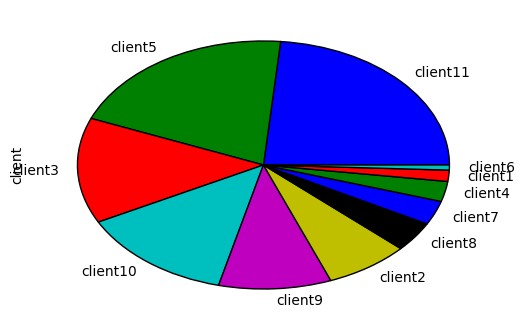

In [15]:
# Display a pie chart for proportions of hires by client
hires.client.value_counts().plot(x=None, y=None, kind='pie')

In [19]:
# Calculate applicant-to-hire ratio
apps_prop = apps.client_name.value_counts()
hires_prop = hires.client.value_counts()[apps_prop.index.tolist()]

apps_to_hire = pd.DataFrame(
    dict(applied=apps_prop,
         hired=hires_prop,
         ratio = apps_prop/hires_prop
         )
).sort_values(by='ratio', ascending=False)
print(apps_to_hire)

          applied  hired     ratio
client11     6701   1674  4.002987
client4       676    187  3.614973
client10     2123    961  2.209157
client9       453    696  0.650862


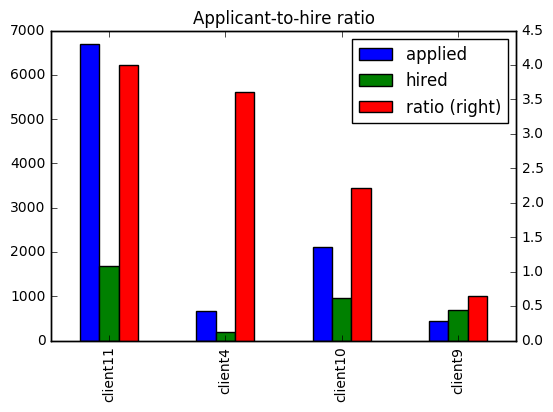

In [20]:
# Display applicant-to-hire ratio
apps_to_hire.plot(x = apps_to_hire.index, kind='bar', title="Applicant-to-hire ratio", secondary_y = 'ratio')

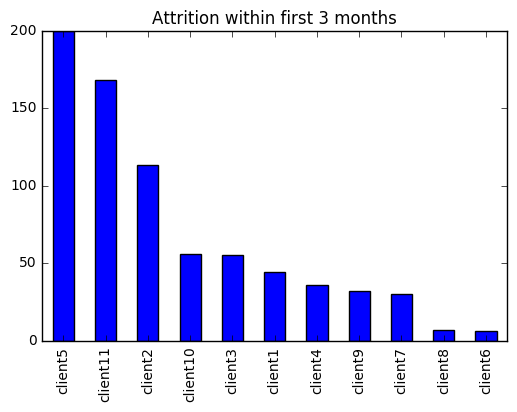

In [21]:
# Attrition within first 3 months
attr90 = hires.iloc[np.where(hires.tenure_length <= 90)]
attr90.client.value_counts().plot(kind='bar', title='Attrition within first 3 months')

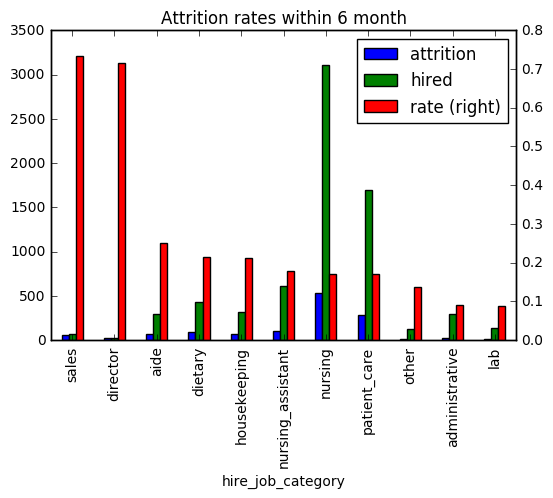

In [24]:
### DATA ANALYSIS ###
# 6-month attrition analysis
attr180 = hires.iloc[np.where(hires.tenure_length <= 180)]
attr180_by_jobs = attr180.groupby('hire_job_category').count().user_id
hired_by_jobs = hires.groupby('hire_job_category').count().user_id[attr180_by_jobs.index.tolist()]
attr_by_jobs = pd.DataFrame(
    dict(
        hired = hired_by_jobs,
        attrition = attr180_by_jobs,
        rate = attr180_by_jobs / hired_by_jobs
    )
).sort_values(by='rate', ascending=False)
attr_by_jobs.plot(kind='bar', title='Attrition rates within 6 month', secondary_y='rate')

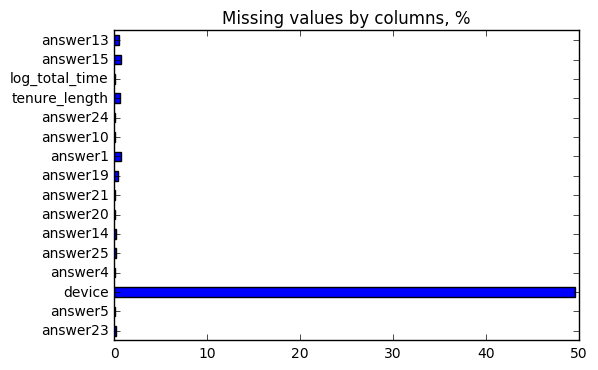

In [28]:
# The effect on the tenure's length by device type used to take the questionnaire
# Find columns with missing values
nulls = both.isnull().any()
nulls = nulls.loc[nulls == True].index.tolist()
nans = dict()
for c in nulls:
    nans[c] = round(both[c].isnull().value_counts()[True] / len(both), 4) * 100
nans = pd.Series(nans, index=nans.keys())
nans.plot(kind='barh', title='Missing values by columns, %')

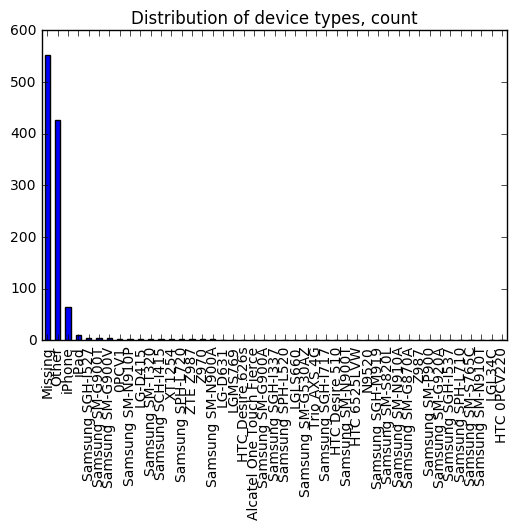

In [41]:
# What the distribution of mean and median tenure's length by device type looks like
# replace nulls with 'missing' in device column
both.loc[both.device.isnull(), 'device'] = 'Missing'
device_counts = both.device.value_counts()
device_counts.plot(kind='bar', title="Distribution of device types, count", xlim=(0, 200))

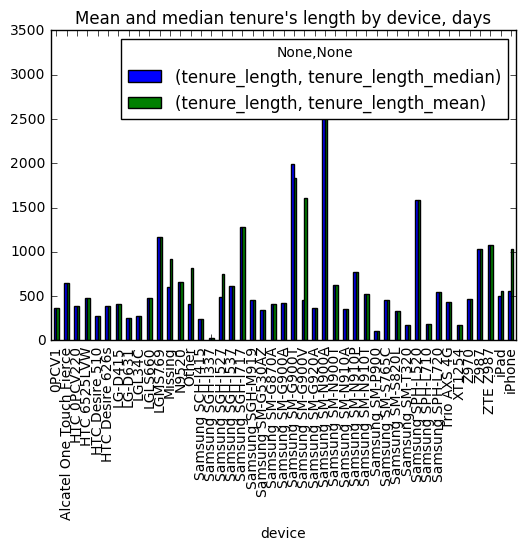

In [42]:
# How the distribution of mean and median tenure's length by device looks like?
tenure_by_device = both.loc[both.device.notnull(),:].groupby('device').\
    agg({'tenure_length': {'tenure_length_mean': np.mean, 'tenure_length_median': np.median}})
tenure_by_device.plot(kind='bar', title="Mean and median tenure's length by device, days", xlim=(0, 1000))

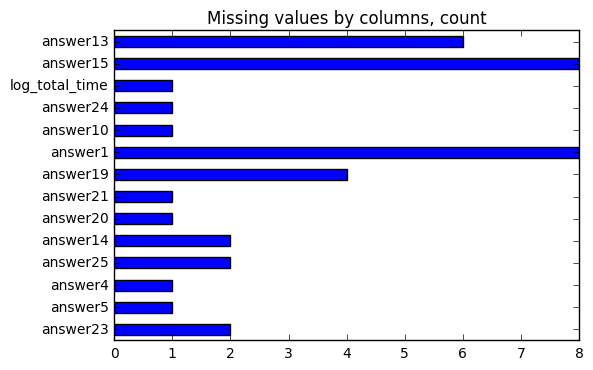

In [45]:
# Get the number of rows with missing values across all the columns
nulls = both.isnull().any()
nulls = nulls.loc[nulls == True].index.tolist()
nans = dict()
for c in nulls:
    nans[c] = both[c].isnull().value_counts()[True]
nans = pd.Series(nans, index=nans.keys())
nans.plot(kind='barh', title='Missing values by columns, count')

In [49]:
# Drop device columns due to a high number of missing values
both = both.drop('device', axis=1)

# Remove rows with missing tenure_length from the data set
no_tenure = both.loc[both.tenure_length.isnull()]
both = both.loc[both.tenure_length.notnull()]

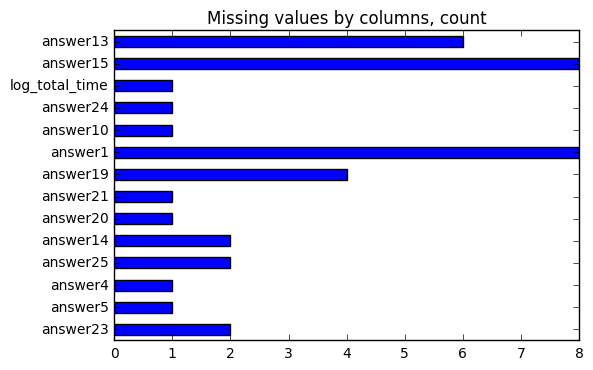

In [50]:
# Create a brand new target column labeling it with accordance to the requirements:
# 1: tenure_lenght < 6 months
# 2: 6 months <= tenure_length <= 12 months
# 3: tenure_length > 12 months
both.loc[both.tenure_length < 180, 'target'] = 1
both.loc[(both.tenure_length >= 180) & (both.tenure_length <= 360), 'target'] = 2
both.loc[both.tenure_length > 360, 'target'] = 3
both.target = both.target.astype(int)

# Get the number of rows with missing values across all the columns
nulls = both.isnull().any()
nulls = nulls.loc[nulls == True].index.tolist()
nans = dict()
for c in nulls:
    nans[c] = both[c].isnull().value_counts()[True]
nans = pd.Series(nans, index=nans.keys())
nans.plot(kind='barh', title='Missing values by columns, count')

In [51]:
# From the graph above it is clear that we can remove rows with missing values as their number is very small
# also we need to cast a few columns into category for further encoding
both = both.dropna()
both.client_name = both.client.astype('category')

# Create train set and the target
y = pd.Series(both.target, index=both.index)
train_features = apps.columns.tolist()[1:-1]
df = pd.DataFrame(both[train_features], index=both.index)
dummies = pd.DataFrame(pd.get_dummies(df.client_name), index=df.index)
X = pd.concat([df.drop('client_name', axis=1), dummies], axis=1)

# Abs to fix answer3 and answer4 negative values
X = X.apply(lambda c: abs(c))

Iteration: 1	Accuracy score 0.956
Classification report:

             precision    recall  f1-score   support

        1.0       0.94      0.92      0.93       137
        2.0       0.95      0.91      0.93       162
        3.0       0.96      0.98      0.97       565

avg / total       0.96      0.96      0.96       864

Iteration: 2	Accuracy score 0.9642
Classification report:

             precision    recall  f1-score   support

        1.0       0.98      0.89      0.93       119
        2.0       0.96      0.95      0.95       195
        3.0       0.96      0.99      0.97       551

avg / total       0.96      0.96      0.96       865



Iteration: 3	Accuracy score 0.9585
Classification report:

             precision    recall  f1-score   support

        1.0       0.94      0.90      0.92       137
        2.0       0.95      0.95      0.95       186
        3.0       0.97      0.98      0.97       544

avg / total       0.96      0.96      0.96       867

Iteration: 4	Accuracy score 0.9653
Classification report:

             precision    recall  f1-score   support

        1.0       0.97      0.92      0.95       127
        2.0       0.97      0.94      0.95       211
        3.0       0.96      0.99      0.97       527

avg / total       0.97      0.97      0.97       865



Iteration: 5	Accuracy score 0.9596
Classification report:

             precision    recall  f1-score   support

        1.0       0.94      0.91      0.92       128
        2.0       0.96      0.93      0.94       190
        3.0       0.96      0.98      0.97       549

avg / total       0.96      0.96      0.96       867



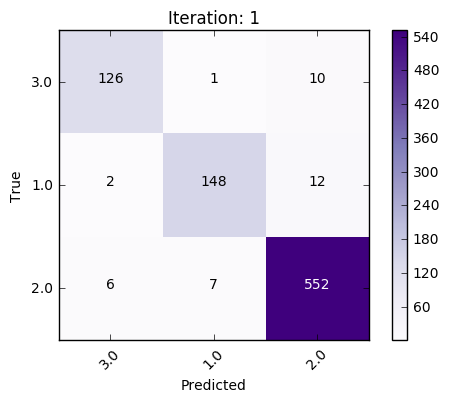

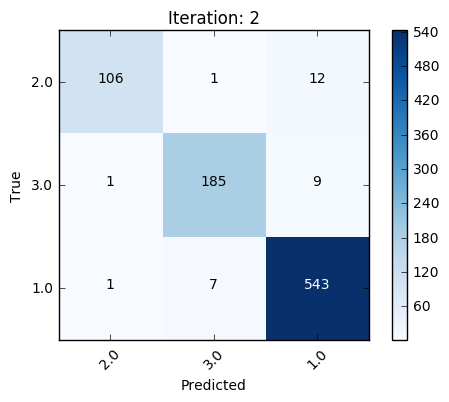

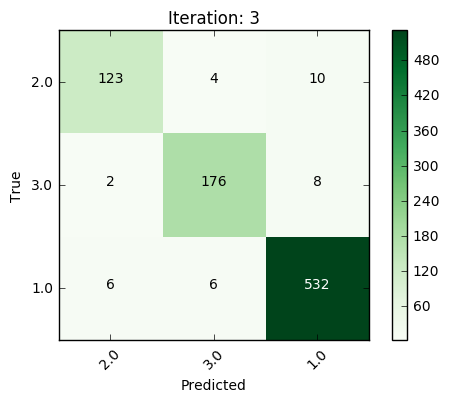

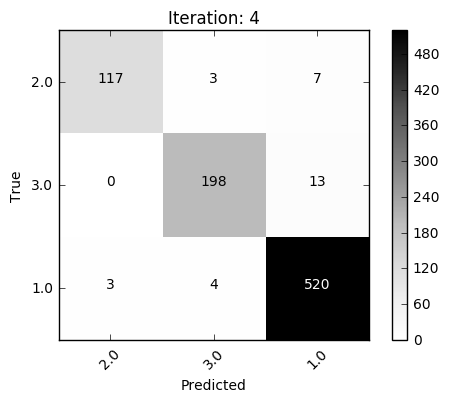

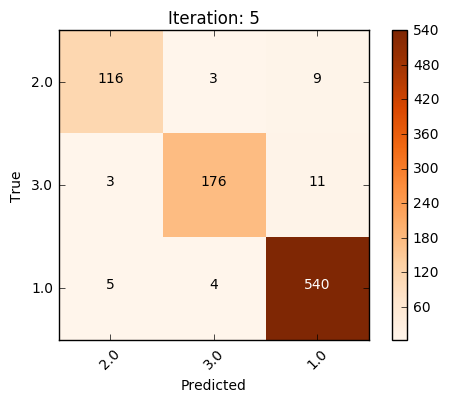

In [57]:
# Fit model using Random Forest
cv = StratifiedKFold(n_splits=5)
rfc = ensemble.RandomForestClassifier()

# Iterrate over a cross-validated set, printing the accuracy score and
# classification report, including precision and recall
iter=0
color_maps = ['Purples', 'Blues', 'Greens', 'Greys', 'Oranges']
for (train, test), color in zip(cv.split(X, y), color_maps):
    X_x, y_y = X.loc[train].dropna(), y.loc[train].dropna()
    iter += 1
    y_score = rfc.fit(X_x, y_y).score(X_x, y_y)
    y_pred = rfc.predict(X_x)
    print("Iteration: {}\tAccuracy score {}\nClassification report:\n".format(iter, round(y_score, 4)))
    print(classification_report(y_y, y_pred))
    plt.figure()
    plot_cm(confusion_matrix(y_y, y_pred), y_y.unique(), title="Iteration: {}".format(iter), cmap=color)
plt.show()